# Exploring Neural Collaborative Filtering

Recommender systems have become integral to our daily lives.  A common method for apporaching recommender systems is collaborative filtering.  Collaborative filtering models a user's preferences via their interactions with the items that may be potentially recommended.  Matrix Factorization (MF) was the predominant machine learning model of collobrative filtering.  In this framework, the users and items are projected into a latent space.  Users and items are represented as vectors in this space.  The user's interaction with the items is then modelled by taking the inner product of the two vectors.  Neural Collaborative Filtering (NCF) was introduced in [this](https://arxiv.org/abs/1708.05031)
 paper and is a generalization that models user interactions with items with a neural network.  A simple case of this is Generalized Matrix Factorization (GMF).  In this framework, the estimated interaction $\hat{y}_{ui}$ between user $u$ and item $i$ is computed by

\begin{equation}
\hat{y}_{ui} = a_{out}(h^{T}(p_{u}\odot q_{i}))
\end{equation}

where $p_{u}$ is the latent representation of user $u$, $q_{i}$ is the latent representation of item $i$, $a_{out}$ is an activation function, and $\hat{y}_{ui}$ is a score between 0 and 1 that estimates the relevance of item $i$ to user $u$.  This can be viewed as a kind of one-layer neural network.  If $h$ is a vector of all ones and $a_{out}$ is the identity function, then GMF becomes MF.

In another approach to neural collaborative filtering, a multi-layer perceptron (MLP) is used to model interactions between users and items.  Let $p_{u}$ and $q_{i}$ be as before.  Then we can define an MLP as follows:

\begin{equation}
z_{1} = \phi_{1}(p_{u},q_{i}) = \begin{bmatrix}p_{u} \\ q_{u} \end{bmatrix}
\end{equation}

\begin{equation}
\phi_{2}(z_{1}) = a_{2}\left(W^{T}_{2}z_{1} + b_{2} \right)
\end{equation}
\begin{equation}
\cdots
\end{equation}
\begin{equation}
\phi_{L}(z_{L-1}) = a_{2}\left(W^{T}_{L}z_{L-1} + b_{L} \right)
\end{equation}
\begin{equation}
\hat{y}_{ui} = \sigma \left(h^{T}\phi_{L}(z_{L-1})\right)
\end{equation}

Note $\sigma$ is the sigmoid function and $h$ is a vector called the predictive factors. 

In yet a third method of NCF, we can combine the MLP and GMF approaches.  To this end, define

\begin{equation}
\phi^{GMF} = (p_{u}\odot q_{i})
\end{equation}
\begin{equation}
\phi^{MLP} = \phi_{L}(z_{L-1})
\end{equation}
\begin{equation}
\hat{y}_{ui} = \sigma \left(h^{T}\begin{bmatrix}\phi^{GMF} \\ \phi^{MLP} \end{bmatrix}\right)
\end{equation}

This method is known as NeuMF.  One way to think of this architecture is that it is a neural network with both a shallow component, given by GMF, and a deep componenet, given by the MLP.

Negative sampling is used to train these NCF.  To this end, let $Y$ be all observed interactions of the form $(u,i)$ and $Y^{-}$ be the negative samples.  Then, the likelihood is

\begin{equation}
\prod_{(u,i)\in Y}\hat{y}_{ui}\prod_{(u,j)\in Y^{-}}(1-\hat{y}_{uj})
\end{equation}

Taking the negative log of the likelihood results in the binary cross-entropy loss function (BCE).  Therefore, training a NCF model amounts to minimizing the BCE.

There are number of methods by which to evaluate a recommender system.  There are two that are of interest to this report.  This first is Hit@k.  To compute this metric, first, for each user, we take one item that the user has interacted with and 100 that they did not.  Then, we score 1 if the item the user has interacted with is in the top k recommendations among the 101 items and 0 otherwise.  We average this over all users.  So,

\begin{equation}
Hit@k = \frac{1}{N}\sum_{u\in U}\mathbf{1}\{ rank_{u,g_{u}} < k\}
\end{equation}

where $N$ is the number of users, $U$ is the set of users, and $rank_{u,g_{u}}$ is the ranking of the ground-truth item $g_{u}$.  The second evaluation metric is the Normalized Discounted Cumulative Gradient at k (NDCG@k).  This is defined for a single user $u$ as

\begin{equation}
NDCG@k = \frac{DCG@k}{IDCG@k}
\end{equation}

Here, $DCG@k = \sum_{i=1}^{k}\frac{y_{ui}}{log_{2}(i+1)}$ where the items $1, \dots, k$ are in sorted in decreasing order according to $\hat{y}_{ui}$, and $IDCG@k$, or the ideal DCG@k, is defined similarly but the items are sorted in decreasing order according to $y_{ui}$.

The Movielens 1M dataset is a popular dataset for evaluating recommender systems.  The dataset consists of a set of users together with the ratings users have given to a large selection of movies.  Users do not usually have a rating for every movie.  To make this dataset fit the binary nature of the problem setting, a movie is marked with a 1 when a user has rated it and a 0 otherwise.

In this report, I will be exploring all three of the NCF methods using the Movielens dataset.  In particular, I am interested in exploring the embedding dimensions of $p_{u}$ and $q_{i}$.  I will look at dimensions 8 and 16.  I am also interested in the dimension of the predictive factors vector $h$.  I will be looking at dimensions 8, 16, 32, and 64.  To evaluate each NCF model according to these dimensions, I will be using $Hit@10$ and $NDCG@10$.  


## Defining Dataset and Models

In [6]:
#Importing Libraries

import pickle
import math
import heapq
import copy
import scipy.sparse as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn


In [7]:
#Class for handling movielens dataset

class MovieLensDataset(Dataset):
    'Characterizes the dataset for PyTorch, and feeds the (user,item) pairs for training'

    def __init__(self, file_name, num_negatives_train=5, num_negatives_test=100):
        'Load the datasets from disk, and store them in appropriate structures'

        self.trainMatrix = self.load_rating_file_as_matrix(
            file_name + ".train.rating")
        self.num_users, self.num_items = self.trainMatrix.shape
        # make training set with negative sampling
        self.user_input, self.item_input, self.ratings = self.get_train_instances(
            self.trainMatrix, num_negatives_train)
        # make testing set with negative sampling
        self.testRatings = self.load_rating_file_as_list(
            file_name + ".test.rating")
        self.testNegatives = self.create_negative_file(
            num_samples=num_negatives_test)
        assert len(self.testRatings) == len(self.testNegatives)

    def __len__(self):
        'Denotes the total number of rating in test set'
        return len(self.user_input)

    def __getitem__(self, index):
        'Generates one sample of data'

        # get the train data
        user_id = self.user_input[index]
        item_id = self.item_input[index]
        rating = self.ratings[index]

        return {'user_id': user_id,
                'item_id': item_id,
                'rating': rating}

    def get_train_instances(self, train, num_negatives):
        user_input, item_input, ratings = [], [], []
        num_users, num_items = train.shape
        for (u, i) in train.keys():
            # positive instance
            user_input.append(u)
            item_input.append(i)
            ratings.append(1)
            # negative instances
            for _ in range(num_negatives):
                j = np.random.randint(1, num_items)
                # while train.has_key((u, j)):
                while (u, j) in train:
                    j = np.random.randint(1, num_items)
                user_input.append(u)
                item_input.append(j)
                ratings.append(0)
        return user_input, item_input, ratings

    def load_rating_file_as_list(self, filename):
        ratingList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])
                ratingList.append([user, item])
                line = f.readline()
        return ratingList

    def create_negative_file(self, num_samples=100):
        negativeList = []
        for user_item_pair in self.testRatings:
            user = user_item_pair[0]
            item = user_item_pair[1]
            negatives = []
            for t in range(num_samples):
                j = np.random.randint(1, self.num_items)
                while (user, j) in self.trainMatrix or j == item:
                    j = np.random.randint(1, self.num_items)
                negatives.append(j)
            negativeList.append(negatives)
        return negativeList

    def load_rating_file_as_matrix(self, filename):
        '''
        Read .rating file and Return dok matrix.
        The first line of .rating file is: num_users\t num_items
        '''
        # Get number of users and items
        num_users, num_items = 0, 0
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                u, i = int(arr[0]), int(arr[1])
                num_users = max(num_users, u)
                num_items = max(num_items, i)
                line = f.readline()
        # Construct matrix
        mat = sp.dok_matrix((num_users+1, num_items+1), dtype=np.float32)
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
                if (rating > 0):
                    mat[user, item] = 1.0
                line = f.readline()
        return mat

In [8]:
#Functions to help compute hit@k and ndcg@k

def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0


def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

In [35]:
class NeuMF(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        
        #Whether or not to have dropout
        self.__dropout__ = kwargs['dropout']
        #List of output dimensions of MLP FC layers
        self.layers = kwargs['layers']
        self.__alias__ = "MLP {}".format(self.layers)
        #Embedding dimensions
        self.embedding_dim_mf = kwargs['MF embedding dimension']
        self.embedding_dim_mlp = kwargs['MLP embedding dimension']
        #Either 'GMF', 'MLP' or 'NeuMF'
        self.method = kwargs['Method']
        #Loss function to use
        self.loss_function = kwargs['Loss Function']
        #Optimizer to use
        self.optimizer = kwargs['Optimizer']
        #Total epochs to train for
        self.epochs = kwargs['Epoch']
        #Device to use
        self.device = kwargs['Device']
        #Number of negative examples to use during training
        self.num_negative_train = kwargs['Number of Negative Train Examples']
        #Number of negative examples to use during testing
        self.num_negative_test = kwargs['Number of Negative Test Examples']
        #Batch size
        self.batch_size = kwargs['Batch Size']
        #Weight decay for optimizer
        self.weight_decay = kwargs['Weight Decay']
        #Learning rate for optimzer
        self.lr = kwargs['LR']
        #the k of topk
        self.topk = kwargs['TopK']

        #Define dataset and dataset related variables
        self.full_dataset = MovieLensDataset('movielens', self.num_negative_train, self.num_negative_test)
        self.train_matrix = self.full_dataset.trainMatrix
        self.train_dl = DataLoader(self.full_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)
        self.val_ratings = self.full_dataset.testRatings[:100]
        self.val_negatives = self.full_dataset.testNegatives[:100]
        self.test_ratings = self.full_dataset.testRatings[100:]
        self.test_negatives = self.full_dataset.testNegatives[100:]
        self.n_users = self.train_matrix.shape[0]
        self.n_items = self.train_matrix.shape[1]

        #Dictionary for storing results
        self.history = {'train loss': [],
                        'val HR': [],
                        'val NDCG': [],
                        'test HR': None,
                        'test NDCG': None}

        #Store the best state found during validation
        self.best_state = None

        if self.method == 'MLP' or self.method == 'NeuMF':

            #Define MLP embeddings if needed
            self.user_embedding_mlp = torch.nn.Embedding(self.n_users, self.embedding_dim_mlp)
            self.item_embedding_mlp = torch.nn.Embedding(self.n_items, self.embedding_dim_mlp)

            #Define FC layers of MLP if needed
            self.fc_layers = torch.nn.ModuleList()

            first_dim = [self.embedding_dim_mlp*2]
            for _, (in_size, out_size) in enumerate(zip(first_dim+self.layers[:-1], self.layers[:])):
                self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        if self.method == 'GMF' or self.method == 'NeuMF':

            #Define embeddings of GMF if needed
            self.user_embedding_mf = torch.nn.Embedding(self.n_users, self.embedding_dim_mf)
            self.item_embedding_mf = torch.nn.Embedding(self.n_items, self.embedding_dim_mf)

        #Define output layer (predictive layer) depending on method
        if self.method == 'GMF':
            self.output_layer = torch.nn.Linear(self.embedding_dim_mf, 1)

        if self.method == 'MLP':
            self.output_layer = torch.nn.Linear(self.layers[-1], 1)

        if self.method == 'NeuMF':
            self.output_layer = torch.nn.Linear(self.embedding_dim_mf+self.layers[-1], 1)


    def forward(self, feed_dict):
        users = feed_dict['user_id']
        items = feed_dict['item_id']

        #If MLP or NeuMF method, push through FC layers
        if self.method == 'MLP' or self.method == 'NeuMF':
            user_embedding_mlp = self.user_embedding_mlp(users)
            item_embedding_mlp = self.item_embedding_mlp(items)
            x = torch.cat([user_embedding_mlp, item_embedding_mlp], 1)
            for idx, _ in enumerate(range(len(self.fc_layers))):
                x = self.fc_layers[idx](x)
                x = F.relu(x)
                x = F.dropout(x,  p=self.__dropout__, training=self.training)

        #If GMF or NeuMF method, do generalized matrix factorization
        if self.method == 'GMF' or self.method == 'NeuMF':
            user_embedding_mf = self.user_embedding_mf(users)
            item_embedding_mf = self.item_embedding_mf(items)
            mf_vector = user_embedding_mf*item_embedding_mf

        #Push through output layer depending on method
        if self.method == 'MLP':
            logit = self.output_layer(x)

        if self.method == 'GMF':
            logit = self.output_layer(mf_vector)

        if self.method == 'NeuMF':
            x = torch.cat([x,mf_vector],1)
            logit = self.output_layer(x)

        #Get final rating
        rating = torch.sigmoid(logit)

        return rating

    def evaluate(self, mode='test'):
        """
        Evaluate model in either validation or test mode
        returns hit@k and NDCG@k averaged over validation or test data
        """

        self.eval()

        hits, ndcgs = [], []

        #Get data depending on mode
        if mode == 'test':
            ratings = self.test_ratings
            negatives = self.test_negatives

        if mode == 'val':
            ratings = self.val_ratings
            negatives = self.val_negatives

        for idx in range(len(ratings)):
            rating = ratings[idx]
            items = negatives[idx]
            u = rating[0]

            gtItem = rating[1]
            items.append(gtItem)
            map_item_score = {}
            users = np.full(len(items), u, dtype='int32')

            feed_dict = {
                'user_id': users,
                'item_id': np.array(items)
            }
            #Get predictions
            predictions = self.predict(feed_dict)
            for i in range(len(items)):
                item = items[i]
                map_item_score[item] = predictions[i]
            #Rank items
            ranklist = heapq.nlargest(self.topk, map_item_score, key=map_item_score.get)
            #Get hit@k
            hr = getHitRatio(ranklist, gtItem)
            hits.append(hr)
            #Get NDCG@k
            ndcg = getNDCG(ranklist, gtItem)
            ndcgs.append(ndcg)
        return sum(hits)/len(hits), sum(ndcgs)/len(ndcgs)

    def fit(self):
        """
        Train Model
        """

        self.to(self.device)

        self.train()

        optimizer = self.optimizer(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        best_hr = 0.0

        for epoch in range(self.epochs):
            #Train Step
            epoch_loss = []
            for feed_dict in self.train_dl:
                for key in feed_dict:
                    if type(feed_dict[key]) != type(None):
                        feed_dict[key] = feed_dict[key].to(dtype=torch.long, device=self.device)
                #Predict
                prediction = self(feed_dict)
                #Get ratings
                rating = feed_dict['rating']
                rating = rating.float().view(prediction.size()) 
                #Get loss 
                loss = self.loss_function(prediction, rating)
                epoch_loss.append(loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            #save train loss
            self.history['train loss'].append(sum(epoch_loss)/len(epoch_loss))
            #Val Step
            hr, ndcg = self.evaluate(mode='val')
            self.history['val HR'].append(hr)
            self.history['val NDCG'].append(ndcg)

            #Save state dict if best model
            if hr > best_hr:
                best_hr = hr
                self.best_state = copy.deepcopy(self.state_dict())


            print('Epoch %02d/%02d | Train Loss: %.4f | Val HR: %.4f | Val NDCG %.4f' % (epoch+1,
                                                                                         self.epochs,
                                                                                         self.history['train loss'][-1],
                                                                                         self.history['val HR'][-1],
                                                                                         self.history['val NDCG'][-1]))
            
    def test(self):
        """
        Test model
        """
        #Load best state
        self.load_state_dict(self.best_state)
        #Evaluate
        hr, ndcg = self.evaluate(mode='test')
        self.history['test HR'] = hr
        self.history['test NDCG'] = ndcg


    def predict(self, feed_dict):
        """
        Predict based on feed_dict
        returns scores for items
        """
        for key in feed_dict:
            if type(feed_dict[key]) != type(None):
                feed_dict[key] = torch.from_numpy(
                    feed_dict[key]).to(dtype=torch.long, device=self.device)
        output_scores = self.forward(feed_dict)
        return output_scores.cpu().detach().numpy()

    def get_alias(self):
        return self.__alias__

    def save_model(self, name):
        """
        Given filename, saves best state dict
        """
        torch.save(self.best_state, name)

    def save_results(self, name):
        """
        Given filename, saves results dict
        """
        f = open(name,"wb")
        pickle.dump(self.history,f)
        f.close()



## Training/Validation/Testing

I will be training GMF, MLP, and NeuMF models.  In particular, I will be looking at embedding dimensions of 8 and 16 and predictive factor dimensions of 8, 16 ,32 ,and 64.  In the case of the GMF, the embedding dimension and predictive factor dimension must be equal, so there will be 4 models trained.  For the MLP models, I will use three layers in addition to the embedding layer and the predictive factor layer.  I use the following strategy to determine the output dimension of each layer:

Layer 1 = Embedding Dimension $\times$ 4

Layer 2 = 16 if predictive factor dimension is less than or equal to 16; 32 for predictive factor dimension of 32; and 64 for predictive factor dimension of 64

Layer 3 = Predictive Factor Dimension

The MLP portion of the NeuMF models will have a similar architecture.  However, we must divide the output dimension of Layer 3 by 2 to accomodate the fact that half of the predictive factors come from the GMF portion of the model

I train each model for 50 epochs using a learning rate of 0.001 with the Adam optimizer and a batch size of 256.  Each training epoch is followed with validation on a validation dataset.  Using the Hit@10 metric on the validation dataset, the best state dictionary is saved after the best performing epoch.

Testing is performed on the test dataset using the final saved state dictionary.

In [36]:
#List for storing model names - will be useful for saving files, plotting

mlp_model_names = []

In [37]:
#Train/Test MLP

#list of embedding dimensions
embeddings = [8, 16]

for emb in embeddings:
    #These are the 4 general architectures for each embedding
    mlp_archs = [[emb*4, 16, 8], [emb*4, 16, 16], [emb*4, 32, 32], [emb*4, 64, 64]]
    for arch in mlp_archs:
        #Define model params
        params = {'dropout': 0.0,
                  'layers': arch,
                  'MLP embedding dimension': emb,
                  'MF embedding dimension': 0,
                  'Method': 'MLP',
                  'Loss Function': torch.nn.BCELoss(),
                  'Optimizer': torch.optim.Adam,
                  'Epoch': 50,
                  'Device': 'cuda',
                  'Number of Negative Train Examples': 5,
                  'Number of Negative Test Examples': 100,
                  'Batch Size': 256,
                  'Weight Decay': 0.00001,
                  'TopK': 10,
                  'LR': 0.001}
        #Define model name
        model_name = 'MLP_'+str(arch)
        mlp_model_names.append(model_name)
        print('Training Model: ', model_name)
        #Initialize model
        model = NeuMF(**params)
        #Train
        model.fit()
        print('Testing Model: ', model_name)
        #Test
        model.test()
        print('Model %s achieved %.4f test HR' % (model_name, model.history['test HR']))
        #Save model and results
        print('Saving Model ', model_name)
        model.save_model(model_name+'.pt')
        model.save_results(model_name+'.pkl')



Training Model:  MLP_[32, 16, 8]
Epoch 01/50 | Train Loss: 0.3920 | Val HR: 0.5200 | Val NDCG 0.2789
Epoch 02/50 | Train Loss: 0.3285 | Val HR: 0.5100 | Val NDCG 0.2628
Epoch 03/50 | Train Loss: 0.3229 | Val HR: 0.5100 | Val NDCG 0.2632
Epoch 04/50 | Train Loss: 0.3194 | Val HR: 0.5000 | Val NDCG 0.2682
Epoch 05/50 | Train Loss: 0.3171 | Val HR: 0.4800 | Val NDCG 0.2667
Epoch 06/50 | Train Loss: 0.3148 | Val HR: 0.5300 | Val NDCG 0.2743
Epoch 07/50 | Train Loss: 0.3118 | Val HR: 0.5000 | Val NDCG 0.2670
Epoch 08/50 | Train Loss: 0.3075 | Val HR: 0.4800 | Val NDCG 0.2755
Epoch 09/50 | Train Loss: 0.3019 | Val HR: 0.5000 | Val NDCG 0.2940
Epoch 10/50 | Train Loss: 0.2957 | Val HR: 0.4800 | Val NDCG 0.2891
Epoch 11/50 | Train Loss: 0.2904 | Val HR: 0.4700 | Val NDCG 0.2730
Epoch 12/50 | Train Loss: 0.2860 | Val HR: 0.5600 | Val NDCG 0.3036
Epoch 13/50 | Train Loss: 0.2825 | Val HR: 0.5700 | Val NDCG 0.3065
Epoch 14/50 | Train Loss: 0.2796 | Val HR: 0.5100 | Val NDCG 0.2815
Epoch 15/50 | T

In [38]:
#List for storing model names - will be useful for saving files, plotting

gmf_model_names = []

In [39]:
#Train/Test GMF

#These are the 4 embedding dimensions for the GMFs
embeddings = [8, 16, 32, 64]

for emb in embeddings:
    #Define params
    params = {'dropout': 0.0,
              'layers': None,
              'MLP embedding dimension': 0,
              'MF embedding dimension': emb,
              'Method': 'GMF',
              'Loss Function': torch.nn.BCELoss(),
              'Optimizer': torch.optim.Adam,
              'Epoch': 50,
              'Device': 'cuda',
              'Number of Negative Train Examples': 5,
              'Number of Negative Test Examples': 100,
              'Batch Size': 256,
              'Weight Decay': 0.00001,
              'TopK': 10,
              'LR': 0.001}
    #Define model name
    model_name = 'GMF_'+str(emb)
    gmf_model_names.append(model_name)
    print('Training Model: ', model_name)
    #Initialize model
    model = NeuMF(**params)
    #Train
    model.fit()
    print('Testing Model: ', model_name)
    #Test
    model.test()
    print('Model %s achieved %.4f test HR' % (model_name, model.history['test HR']))
    print('Saving Model ', model_name)
    #Save results and model
    model.save_model(model_name+'.pt')
    model.save_results(model_name+'.pkl')



Training Model:  GMF_8
Epoch 01/50 | Train Loss: 0.5058 | Val HR: 0.1100 | Val NDCG 0.0611
Epoch 02/50 | Train Loss: 0.4508 | Val HR: 0.2100 | Val NDCG 0.1080
Epoch 03/50 | Train Loss: 0.3888 | Val HR: 0.5200 | Val NDCG 0.2474
Epoch 04/50 | Train Loss: 0.3245 | Val HR: 0.5200 | Val NDCG 0.2527
Epoch 05/50 | Train Loss: 0.3216 | Val HR: 0.5100 | Val NDCG 0.2527
Epoch 06/50 | Train Loss: 0.3208 | Val HR: 0.5200 | Val NDCG 0.2629
Epoch 07/50 | Train Loss: 0.3204 | Val HR: 0.5100 | Val NDCG 0.2607
Epoch 08/50 | Train Loss: 0.3202 | Val HR: 0.5000 | Val NDCG 0.2603
Epoch 09/50 | Train Loss: 0.3201 | Val HR: 0.5100 | Val NDCG 0.2666
Epoch 10/50 | Train Loss: 0.3201 | Val HR: 0.5200 | Val NDCG 0.2690
Epoch 11/50 | Train Loss: 0.3200 | Val HR: 0.5100 | Val NDCG 0.2669
Epoch 12/50 | Train Loss: 0.3200 | Val HR: 0.5100 | Val NDCG 0.2626
Epoch 13/50 | Train Loss: 0.3200 | Val HR: 0.5000 | Val NDCG 0.2645
Epoch 14/50 | Train Loss: 0.3200 | Val HR: 0.5100 | Val NDCG 0.2660
Epoch 15/50 | Train Loss:

In [42]:
#List for storing model names - will be useful for saving files, plotting

neumf_model_names = []

In [43]:
#Train/Test NeuMF

#These are the two embedding dimensions to consider
embeddings = [8, 16]

for emb in embeddings:
    #These are the general architectures for each embedding
    mlp_archs = [[emb*4, 16, 4], [emb*4, 16, 8], [emb*4, 32, 16], [emb*4, 64, 32]]
    for arch in mlp_archs:
        #Define params
        params = {'dropout': 0.0,
                  'layers': arch,
                  'MLP embedding dimension': emb,
                  'MF embedding dimension': arch[-1],
                  'Method': 'MLP',
                  'Loss Function': torch.nn.BCELoss(),
                  'Optimizer': torch.optim.Adam,
                  'Epoch': 50,
                  'Device': 'cuda',
                  'Number of Negative Train Examples': 5,
                  'Number of Negative Test Examples': 100,
                  'Batch Size': 256,
                  'Weight Decay': 0.00001,
                  'TopK': 10,
                  'LR': 0.001}
        #Define model name
        model_name = 'NeuMF_'+str(arch)
        neumf_model_names.append(model_name)
        print('Training Model: ', model_name)
        #Initialize model
        model = NeuMF(**params)
        #Train
        model.fit()
        print('Testing Model: ', model_name)
        #Test
        model.test()
        print('Model %s achieved %.4f test HR' % (model_name, model.history['test HR']))
        #Save model and results
        print('Saving Model ', model_name)
        model.save_model(model_name+'.pt')
        model.save_results(model_name+'.pkl')



Training Model:  NeuMF_[32, 16, 4]
Epoch 01/50 | Train Loss: 0.3907 | Val HR: 0.5400 | Val NDCG 0.2791
Epoch 02/50 | Train Loss: 0.3290 | Val HR: 0.5600 | Val NDCG 0.2767
Epoch 03/50 | Train Loss: 0.3243 | Val HR: 0.5400 | Val NDCG 0.2717
Epoch 04/50 | Train Loss: 0.3207 | Val HR: 0.5100 | Val NDCG 0.2633
Epoch 05/50 | Train Loss: 0.3176 | Val HR: 0.5000 | Val NDCG 0.2579
Epoch 06/50 | Train Loss: 0.3145 | Val HR: 0.5300 | Val NDCG 0.2636
Epoch 07/50 | Train Loss: 0.3099 | Val HR: 0.5200 | Val NDCG 0.2848
Epoch 08/50 | Train Loss: 0.3028 | Val HR: 0.5200 | Val NDCG 0.2777
Epoch 09/50 | Train Loss: 0.2941 | Val HR: 0.5500 | Val NDCG 0.2823
Epoch 10/50 | Train Loss: 0.2859 | Val HR: 0.5600 | Val NDCG 0.2690
Epoch 11/50 | Train Loss: 0.2785 | Val HR: 0.5400 | Val NDCG 0.2859
Epoch 12/50 | Train Loss: 0.2731 | Val HR: 0.5400 | Val NDCG 0.2953
Epoch 13/50 | Train Loss: 0.2690 | Val HR: 0.5800 | Val NDCG 0.3249
Epoch 14/50 | Train Loss: 0.2659 | Val HR: 0.5800 | Val NDCG 0.3114
Epoch 15/50 |

## Results

In [92]:
#Getting the train losses for all models

gmf_train_loss = []

for name in gmf_model_names:
    pickle_off = open(name+'pkl',"rb")
    results = pickle.load(pickle_off)
    gmf_train_loss.append(results['train loss'])

mlp_train_loss = []

for name in mlp_model_names:
    pickle_off = open(name+'pkl',"rb")
    results = pickle.load(pickle_off)
    mlp_train_loss.append(results['train loss'])

neumf_train_loss = []

for name in neumf_model_names:
    pickle_off = open(name+'pkl',"rb")
    results = pickle.load(pickle_off)
    neumf_train_loss.append(results['train loss'])

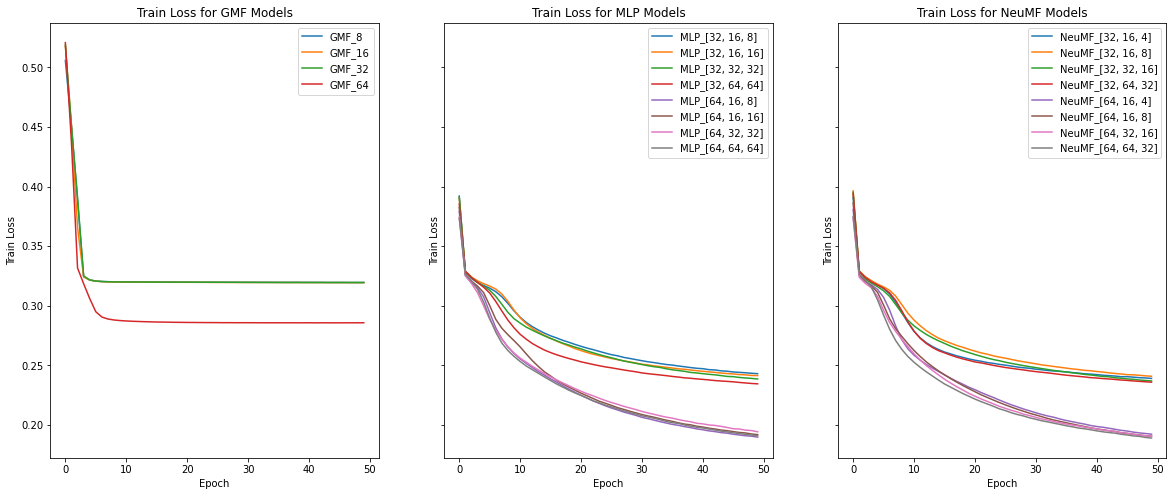

In [96]:
#Plotting train losses

fig, axs = plt.subplots(1, 3, figsize=(20,8), sharey=True)

for loss, name in zip(gmf_train_loss, gmf_model_names):
    axs[0].plot(range(50), loss, label=name)

axs[0].set_title('Train Loss for GMF Models')

for loss, name in zip(mlp_train_loss, mlp_model_names):
    axs[1].plot(range(50), loss, label=name)

axs[1].set_title('Train Loss for MLP Models')

for loss, name in zip(neumf_train_loss, neumf_model_names):
    axs[2].plot(range(50), loss, label=name)

axs[2].set_title('Train Loss for NeuMF Models')

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Train Loss')
    ax.legend()

plt.show()

The train loss behavior for all the models is above.  It can be seen that the loss of all the GMF models flatline very quickly, with the GMF model with predictive factors dimension of 64 achieving a lower loss than the other three models.  The behaviors of the loss of the MLP and NeuMF models are very similar.  In general, the more parameters in the model, the lower the train loss.  Also, we can see a clear separation between the models with embedding dimension 8 (the [32...] models) and the models with embedding dimension 16 (the [64...] models).

In [98]:
#Getting Hit@10 on validation data for all models

gmf_hr = []

for name in gmf_model_names:
    pickle_off = open(name+'pkl',"rb")
    results = pickle.load(pickle_off)
    gmf_hr.append(results['val HR'])

mlp_hr = []

for name in mlp_model_names:
    pickle_off = open(name+'pkl',"rb")
    results = pickle.load(pickle_off)
    mlp_hr.append(results['val HR'])

neumf_hr = []

for name in neumf_model_names:
    pickle_off = open(name+'pkl',"rb")
    results = pickle.load(pickle_off)
    neumf_hr.append(results['val HR'])

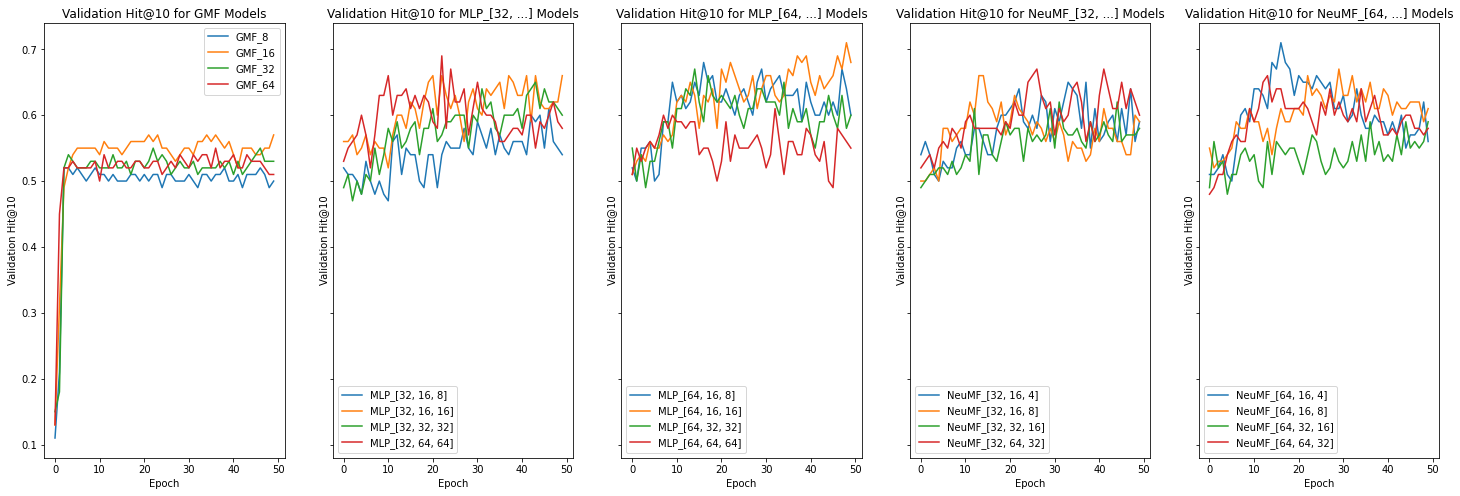

In [103]:
#Plotting validation Hit@10

fig, axs = plt.subplots(1, 5, figsize=(25,8), sharey=True)

for hr, name in zip(gmf_hr, gmf_model_names):
    axs[0].plot(range(50), hr, label=name)

axs[0].set_title('Validation Hit@10 for GMF Models')

for hr, name in zip(mlp_hr[:4], mlp_model_names[:4]):
    axs[1].plot(range(50), hr, label=name)

axs[1].set_title('Validation Hit@10 for MLP_[32, ...] Models')

for hr, name in zip(mlp_hr[4:], mlp_model_names[4:]):
    axs[2].plot(range(50), hr, label=name)

axs[2].set_title('Validation Hit@10 for MLP_[64, ...] Models')

for hr, name in zip(neumf_hr[:4], neumf_model_names[:4]):
    axs[3].plot(range(50), hr, label=name)

axs[3].set_title('Validation Hit@10 for NeuMF_[32, ...] Models')

for hr, name in zip(neumf_hr[4:], neumf_model_names[4:]):
    axs[4].plot(range(50), hr, label=name)

axs[4].set_title('Validation Hit@10 for NeuMF_[64, ...] Models')

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Validation Hit@10')
    ax.legend()

plt.show()

The behaviors of the validation Hit@10 for all the models are in the graphs above.  The GMF models all flatline very quickly.  The medium-sized models somewhat outperform the smaller and larger models.  In the MLP models, in general, the larger the capacity of the models, the quicker the Hit@10 peaks and decays.  However, the same is not true for the NeuMF models.  In many cases, the Hit@10 for the larger models does not peak and decay quickly like the Hit@10 of the smaller models.

In [105]:
#Getting validation NDCG@10 for all models

gmf_ndcg = []

for name in gmf_model_names:
    pickle_off = open(name+'pkl',"rb")
    results = pickle.load(pickle_off)
    gmf_ndcg.append(results['val NDCG'])

mlp_ndcg = []

for name in mlp_model_names:
    pickle_off = open(name+'pkl',"rb")
    results = pickle.load(pickle_off)
    mlp_ndcg.append(results['val NDCG'])

neumf_ndcg = []

for name in neumf_model_names:
    pickle_off = open(name+'pkl',"rb")
    results = pickle.load(pickle_off)
    neumf_ndcg.append(results['val NDCG'])

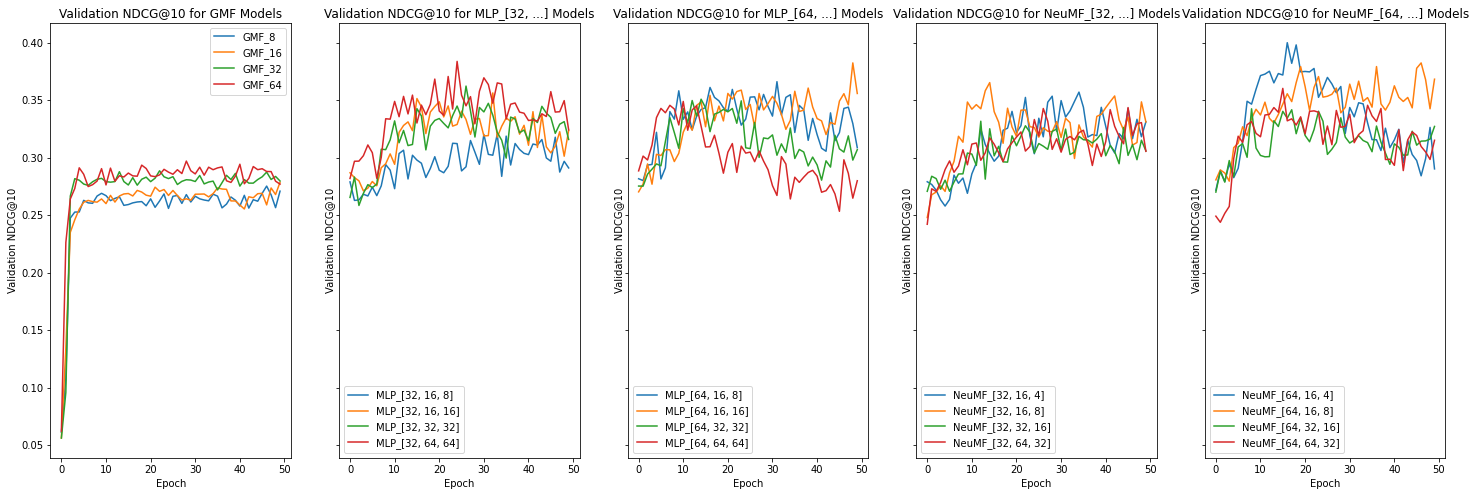

In [106]:
#Plotting validation NDCG@10

fig, axs = plt.subplots(1, 5, figsize=(25,8), sharey=True)

for ndcg, name in zip(gmf_ndcg, gmf_model_names):
    axs[0].plot(range(50), ndcg, label=name)

axs[0].set_title('Validation NDCG@10 for GMF Models')

for ndcg, name in zip(mlp_ndcg[:4], mlp_model_names[:4]):
    axs[1].plot(range(50), ndcg, label=name)

axs[1].set_title('Validation NDCG@10 for MLP_[32, ...] Models')

for ndcg, name in zip(mlp_ndcg[4:], mlp_model_names[4:]):
    axs[2].plot(range(50), ndcg, label=name)

axs[2].set_title('Validation NDCG@10 for MLP_[64, ...] Models')

for ndcg, name in zip(neumf_ndcg[:4], neumf_model_names[:4]):
    axs[3].plot(range(50), ndcg, label=name)

axs[3].set_title('Validation NDCG@10 for NeuMF_[32, ...] Models')

for ndcg, name in zip(neumf_ndcg[4:], neumf_model_names[4:]):
    axs[4].plot(range(50), ndcg, label=name)

axs[4].set_title('Validation NDCG@10 for NeuMF_[64, ...] Models')

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Validation NDCG@10')
    ax.legend()

plt.show()

The behaviors of the validation NDCG@10 are graphed above for each model.  The same behavior observed for the Hit@10 is even more pronounced here.  The larger MLP models are overfitting very quickly while the larger NeuMF models are not.

In [74]:
#Getting GMF Test results

gmf_hr_test_results = []
gmf_ndcg_test_results = []

for name in gmf_model_names:
    pickle_off = open(name+'pkl',"rb")
    results = pickle.load(pickle_off)
    gmf_hr_test_results.append(results['test HR'])
    gmf_ndcg_test_results.append(results['test NDCG'])

gmf_results = {'Model Name': gmf_model_names,
               'Hit@10 Test Results': gmf_hr_test_results,
               'NDCG@10 Test Results': gmf_ndcg_test_results}

gmf_results_df = pd.DataFrame(gmf_results)

In [75]:
gmf_results_df

,Model Name,Hit@10 Test Results,NDCG@10 Test Results
0,GMF_8,0.354686,0.192913
1,GMF_16,0.371293,0.203599
2,GMF_32,0.374852,0.203896
3,GMF_64,0.513642,0.285264


The test results for the GMF models are in the table above.  The models with predictive factor dimensions 8, 16, and 32 all performed very poorly, while the 64 dimensional model performed alright.

In [79]:
#Getting MLP test results

mlp_hr_test_results = []
mlp_ndcg_test_results = []

for name in mlp_model_names:
    pickle_off = open(name+'pkl',"rb")
    results = pickle.load(pickle_off)
    mlp_hr_test_results.append(results['test HR'])
    mlp_ndcg_test_results.append(results['test NDCG'])

mlp_results = {'Model Name': mlp_model_names,
               'Hit@10 Test Results': mlp_hr_test_results,
               'NDCG@10 Test Results': mlp_ndcg_test_results}

mlp_results_df = pd.DataFrame(mlp_results)

In [80]:
mlp_results_df

,Model Name,Hit@10 Test Results,NDCG@10 Test Results
0,"MLP_[32, 16, 8]",0.571767,0.324750
1,"MLP_[32, 16, 16]",0.552788,0.294667
2,"MLP_[32, 32, 32]",0.551601,0.296502
3,"MLP_[32, 64, 64]",0.576512,0.317553
4,"MLP_[64, 16, 8]",0.574140,0.317967
5,"MLP_[64, 16, 16]",0.549229,0.299795
6,"MLP_[64, 32, 32]",0.555160,0.306819
7,"MLP_[64, 64, 64]",0.564650,0.303115


The test results for the MLP models are in the table above. The model that performed the best on the Hit@10 metric was the model with an embedding dimension of 8 but a predictive factor dimesion of 64 (model [32,64,64]).  The model that performed the best on the NDCG@10 metric had an embedding dimesion of 8 and a predictive factor dimension of 8 (model [32,16,8]).  Overall, it is difficult to identify any pattern in these results.  Some larger models did quite fine while some smaller models did poorly and vice versa.  If one is interested in striking a balance between the two metrics, then the smallest model may be the best choice.  

In [81]:
#Getting NeuMF test results

neumf_hr_test_results = []
neumf_ndcg_test_results = []

for name in neumf_model_names:
    pickle_off = open(name+'pkl',"rb")
    results = pickle.load(pickle_off)
    neumf_hr_test_results.append(results['test HR'])
    neumf_ndcg_test_results.append(results['test NDCG'])

neumf_results = {'Model Name': neumf_model_names,
               'Hit@10 Test Results': neumf_hr_test_results,
               'NDCG@10 Test Results': neumf_ndcg_test_results}

neumf_results_df = pd.DataFrame(neumf_results)

In [82]:
neumf_results_df

,Model Name,Hit@10 Test Results,NDCG@10 Test Results
0,"NeuMF_[32, 16, 4]",0.577699,0.323883
1,"NeuMF_[32, 16, 8]",0.523132,0.301854
2,"NeuMF_[32, 32, 16]",0.557533,0.306317
3,"NeuMF_[32, 64, 32]",0.571767,0.321664
4,"NeuMF_[64, 16, 4]",0.571767,0.310371
5,"NeuMF_[64, 16, 8]",0.575326,0.315552
6,"NeuMF_[64, 32, 16]",0.578885,0.312385
7,"NeuMF_[64, 64, 32]",0.557533,0.313410


The test results for the NeuMF models are in the table above.  The model that performed the best on the Hit@10 was the one with an embedding dimension of 16 and a predictive factors dimension of 32 (the [64, 32, 16] model).  The model that achieved the highest NDCG@10 score was the smallest model (the [32, 16, 4] model).  Overall, it is difficult to discern a pattern in these results.  Some big models did fairly well and some did not.

## Conclusion

In this report, I explored three types of neural collaborative filtering models, GMF, MLP, and NeuMF.  The MLP and NeuMF models far outperformed the GMF models on both the Hit@10 and NDCG@10 metrics.  In general, the NeuMF models outperformed the MLP models on the NDCG@10 metric.  However, the situation is a bit more unclear for the Hit@10 metric.  Some NeuMF models outperformed their MLP counterparts and some did not.  Therefore, we might conclude that the choice of evaluation metric may substantially alter the perception of the performance of a model, and care must be taken to look at all available metrics.  For the MLP and NeuMF models, it is difficult to say what embedding dimension and predictive factor dimension is the best, though from the NDCG@10 results, we might tentatively conclude that larger models are possible for the NeuMF scenario.  A possible reason for this is that the shallow portion of the NeuMF architecture acts as a kind of residual connection, which we know can help prevent larger models from overfitting.  It is likely that with larger datasets, the results would be clearer.  In particular, we may find that the larger models perform substantially better.  But in our case, though the dataset used was moderately sized, it may not have been large enough to realize the benefits of the larger models.

The [original keras implementation](https://github.com/hexiangnan/neural_collaborative_filtering) by the authors of the paper was useful for this report.  Also, [this repository](https://github.com/HarshdeepGupta/recommender_pytorch) was helpful, especially for the construction and preparation of the dataset.